DATASET OVERVIEW
Samples: 1866
Features: 13
Time steps (records): 13632
Size: 2522.93 MB

FEATURE STATISTICS (across all samples & locations)
 0. Latitude     | min:      18.65 | max:      53.47 | mean:      33.38
 1. Longitude    | min:      75.25 | max:     133.99 | mean:     112.43
 2. Altitude     | min:     -47.20 | max:    4613.00 | mean:     605.86
 3. Air pressure | min:     564.90 | max:    1050.00 | mean:     948.94
 4. Air Temperature | min:     -17.50 | max:      47.20 | mean:      14.42
 5. Maximum Temperature | min:     -16.85 | max:      48.10 | mean:      14.91
 6. Minimum Temperature | min:     -17.75 | max:      46.90 | mean:      13.94
 7. Relative humidity | min:       0.00 | max:     100.00 | mean:      67.57
 8. Precipitation in 3h | min:      -1.00 | max:    1049.70 | mean:       0.34
 9. Wind direction | min:       0.00 | max:     360.00 | mean:     174.47
10. Wind speed   | min:       0.00 | max:      37.70 | mean:       2.08
11. Maximum wind direction | min:  

c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Unique Latitude values: 1234
Unique Longitude values: 1306
Altitude range: -47m to 4613m


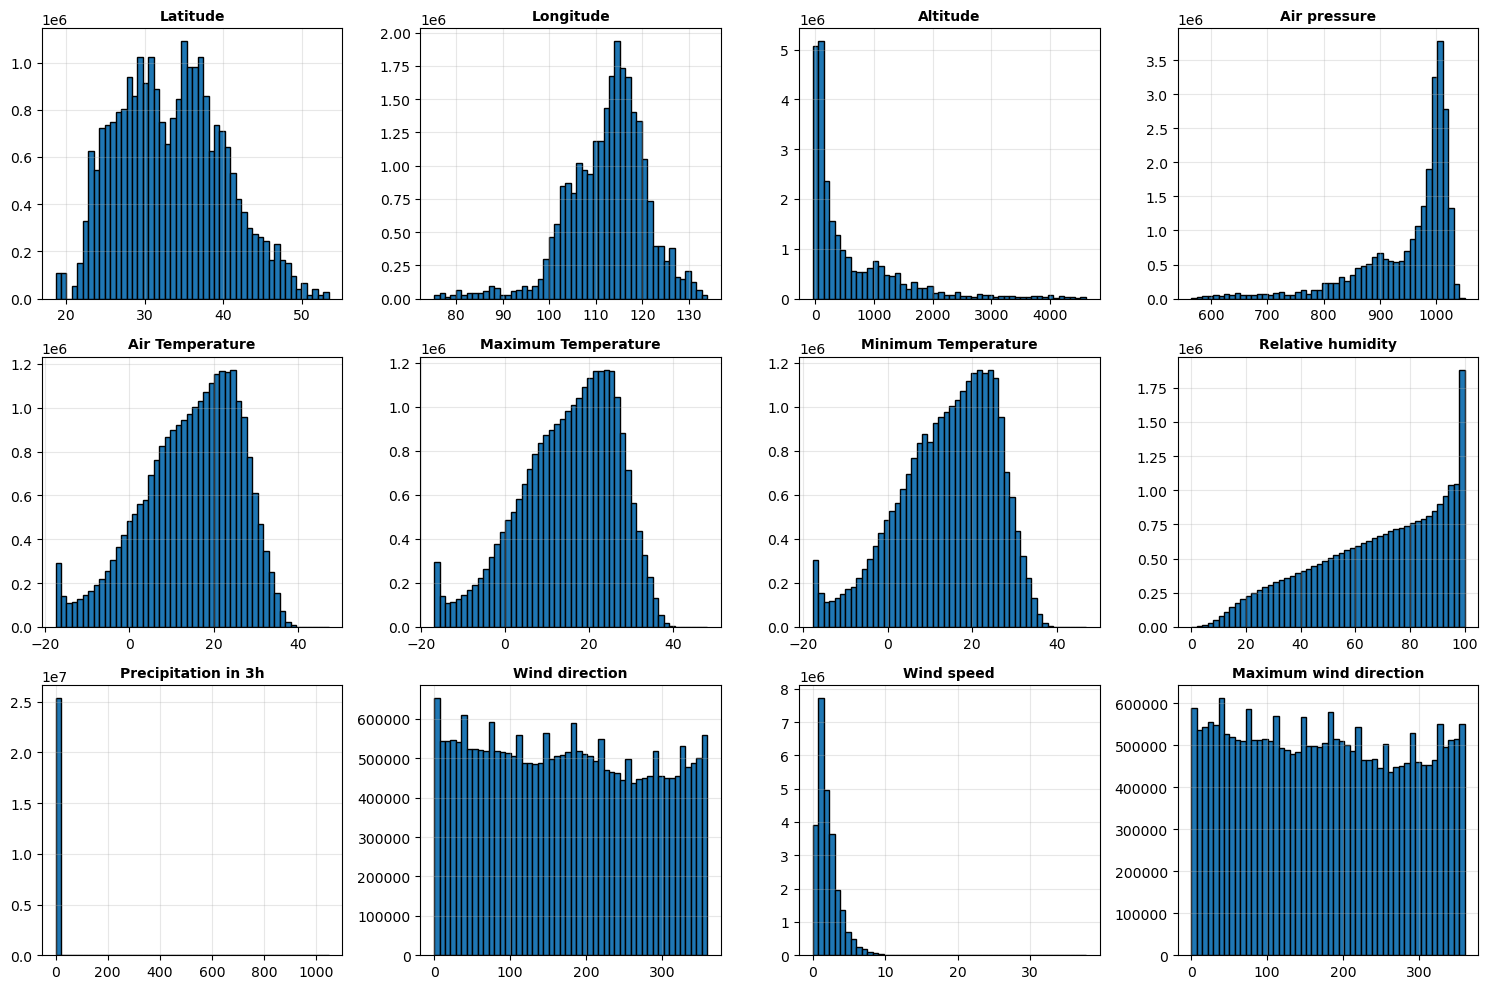

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.load(r"weather2k.npy", allow_pickle=True)

# Feature names
features = ['Latitude', 'Longitude', 'Altitude', 'Air pressure', 'Air Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Relative humidity', 'Precipitation in 3h', 
            'Wind direction', 'Wind speed', 'Maximum wind direction', 'Maximum wind speed']

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Samples: {data.shape[0]}")
print(f"Features: {data.shape[1]}")
print(f"Time steps (records): {data.shape[2]}")
print(f"Size: {data.nbytes / (1024**2):.2f} MB\n")

print("="*60)
print("FEATURE STATISTICS (across all samples & locations)")
print("="*60)
for i, fname in enumerate(features[:data.shape[1]]):
    feature_data = data[:, i, :]
    print(f"{i:2d}. {fname:12s} | min: {feature_data.min():10.2f} | "
          f"max: {feature_data.max():10.2f} | mean: {feature_data.mean():10.2f}")

print("\n" + "="*60)
print("DATA QUALITY CHECK")
print("="*60)
print(f"NaN values: {np.isnan(data).sum()}")
print(f"Inf values: {np.isinf(data).sum()}")
print(f"Zero values: {(data == 0).sum()} ({(data == 0).sum() / data.size * 100:.2f}%)")

print("\n" + "="*60)
print("SAMPLE ANALYSIS")
print("="*60)
print(f"Sample 0 temp range: {data[0, 4, :].min():.1f}°C to {data[0, 4, :].max():.1f}°C")
print(f"Sample 0 humidity range: {data[0, 7, :].min():.1f}% to {data[0, 7, :].max():.1f}%")

# Visualize feature distributions
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(12, data.shape[1])):
    feature_data = data[:, i, :].flatten()
    axes[i].hist(feature_data[~np.isnan(feature_data)], bins=50, edgecolor='black')
    axes[i].set_title(f"{features[i]}", fontsize=10, fontweight='bold')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('weather_features_distribution.png', dpi=100)
print("\n✓ Saved feature distributions to 'weather_features_distribution.png'")

# Correlation analysis
print("\n" + "="*60)
print("FEATURE CORRELATIONS (sample 0)")
print("="*60)
sample_data = data[0, :, :].T  # Transpose to (locations, features)
corr_matrix = np.corrcoef(sample_data.T)

# Show strongest correlations
for i in range(min(5, data.shape[1])):
    for j in range(i+1, min(5, data.shape[1])):
        print(f"{features[i]:6s} vs {features[j]:6s}: {corr_matrix[i, j]:6.3f}")

print("\n" + "="*60)
print("SPATIAL ANALYSIS")
print("="*60)
print(f"Unique Latitude values: {len(np.unique(data[:, 0, :]))}")
print(f"Unique Longitude values: {len(np.unique(data[:, 1, :]))}")
print(f"Altitude range: {data[:, 2, :].min():.0f}m to {data[:, 2, :].max():.0f}m")

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

c:\ProgramData\anaconda3\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Using device: cuda
GPU: NVIDIA GeForce RTX 4060


In [3]:
# Check the original table more carefully
print(f"Total features in data: {data.shape[1]}")
print("\nChecking all features:")

for i in range(data.shape[1]):
    print(f"Index {i}: range [{data[:, i, :].min():.2f}, {data[:, i, :].max():.2f}]")

# Specifically check if 5 and 6 are both temperature-related
print("\n--- Temperature Analysis ---")
print(f"Index 5: {data[:, 5, :].min():.2f} to {data[:, 5, :].max():.2f}")
print(f"Index 6: {data[:, 6, :].min():.2f} to {data[:, 6, :].max():.2f}")

# Check if one is consistently higher (max) than the other (min)
sample_station = 0
sample_time = 100
print(f"\nSample comparison at station {sample_station}, time {sample_time}:")
print(f"Index 5: {data[sample_station, 5, sample_time]:.2f}")
print(f"Index 6: {data[sample_station, 6, sample_time]:.2f}")

Total features in data: 13

Checking all features:
Index 0: range [18.65, 53.47]
Index 1: range [75.25, 133.99]
Index 2: range [-47.20, 4613.00]
Index 3: range [564.90, 1050.00]
Index 4: range [-17.50, 47.20]
Index 5: range [-16.85, 48.10]
Index 6: range [-17.75, 46.90]
Index 7: range [0.00, 100.00]
Index 8: range [-1.00, 1049.70]
Index 9: range [0.00, 360.00]
Index 10: range [0.00, 37.70]
Index 11: range [0.00, 360.00]
Index 12: range [0.00, 48.90]

--- Temperature Analysis ---
Index 5: -16.85 to 48.10
Index 6: -17.75 to 46.90

Sample comparison at station 0, time 100:
Index 5: -14.90
Index 6: -15.30


In [4]:
# apply log transform to the precipitation
# Index 8 is precipitation column
PRECIP_IDX = 8

# Add small constant to avoid log(0), then log transform, the log transform would work because the column data is right-skewed data
data[:, PRECIP_IDX, :] = np.log1p(data[:, PRECIP_IDX, :])  # log1p = log(1 + x)
print(f"Applied log transform to precipitation")

# Wind direction is circular - convert to sin/cos
# Indices 9 and 11 are wind directions
WD_INDICES = [9, 11]

for wd_idx in WD_INDICES:
    # Convert degrees to radians, then to sin/cos
    rad = np.deg2rad(data[:, wd_idx, :])
    sin_component = np.sin(rad)
    cos_component = np.cos(rad)
    
    # Replace original with sin, append cos as new feature
    data[:, wd_idx, :] = sin_component
    # Add cos component as new feature
    cos_feature = cos_component[np.newaxis, :, :]  # Add feature dimension
    data = np.concatenate([data, cos_feature.transpose(1, 0, 2)], axis=1)

print(f"Converted wind directions to sin/cos. New shape: {data.shape}")

C:\Users\mamou\AppData\Local\Temp\ipykernel_37488\2054478675.py:6: RuntimeWarning: divide by zero encountered in log1p
  data[:, PRECIP_IDX, :] = np.log1p(data[:, PRECIP_IDX, :])  # log1p = log(1 + x)


Applied log transform to precipitation
Converted wind directions to sin/cos. New shape: (1866, 15, 13632)


In [5]:
# Original feature names
features = [
    "Latitude", "Longitude", "Altitude", "Air pressure", "Air Temperature",
    "Maximum Temperature", "Minimum Temperature", "Relative humidity",
    "Precipitation", "Wind direction", "Wind speed", "Max wind dir", "Max wind speed"
]

# Add cos features for wind directions
for idx in WD_INDICES:
    features.append(f"{features[idx]}_cos")

print("New feature names:")
# Compute min, max, mean for all features
print("\nFEATURE STATS (with new cos features)")
for i, f in enumerate(features):
    feature_data = data[:, i, :].flatten()
    print(f"{i:2d}. {f:25s} | min: {feature_data.min():10.2f} | max: {feature_data.max():10.2f} | mean: {feature_data.mean():10.2f}")

New feature names:

FEATURE STATS (with new cos features)
 0. Latitude                  | min:      18.65 | max:      53.47 | mean:      33.38
 1. Longitude                 | min:      75.25 | max:     133.99 | mean:     112.43
 2. Altitude                  | min:     -47.20 | max:    4613.00 | mean:     605.86
 3. Air pressure              | min:     564.90 | max:    1050.00 | mean:     948.94
 4. Air Temperature           | min:     -17.50 | max:      47.20 | mean:      14.42
 5. Maximum Temperature       | min:     -16.85 | max:      48.10 | mean:      14.91
 6. Minimum Temperature       | min:     -17.75 | max:      46.90 | mean:      13.94
 7. Relative humidity         | min:       0.00 | max:     100.00 | mean:      67.57
 8. Precipitation             | min:       -inf | max:       6.96 | mean:       -inf
 9. Wind direction            | min:      -1.00 | max:       1.00 | mean:       0.03
10. Wind speed                | min:       0.00 | max:      37.70 | mean:       2.08
11. Max

In [6]:
print(f"Shape: {data.shape}")

# Check for NaN/Inf values
nan_count = np.isnan(data).sum()
inf_count = np.isinf(data).sum()
print(f"NaN values: {nan_count}, Inf values: {inf_count}")

if nan_count > 0 or inf_count > 0:
    for i in range(data.shape[1]):
        feature = data[:, i, :]
        # Calculate median only on finite values
        valid_mask = np.isfinite(feature)
        if valid_mask.any():
            median_val = np.median(feature[valid_mask])
        else:
            median_val = 0.0
        
        # Replace NaN and Inf with median
        data[:, i, :] = np.where(np.isfinite(feature), feature, median_val)
    
    print("Replaced NaN/Inf with median values")
    print(f"After fix - NaN: {np.isnan(data).sum()}, Inf: {np.isinf(data).sum()}")

Shape: (1866, 15, 13632)
NaN values: 0, Inf values: 3645
Replaced NaN/Inf with median values
After fix - NaN: 0, Inf: 0


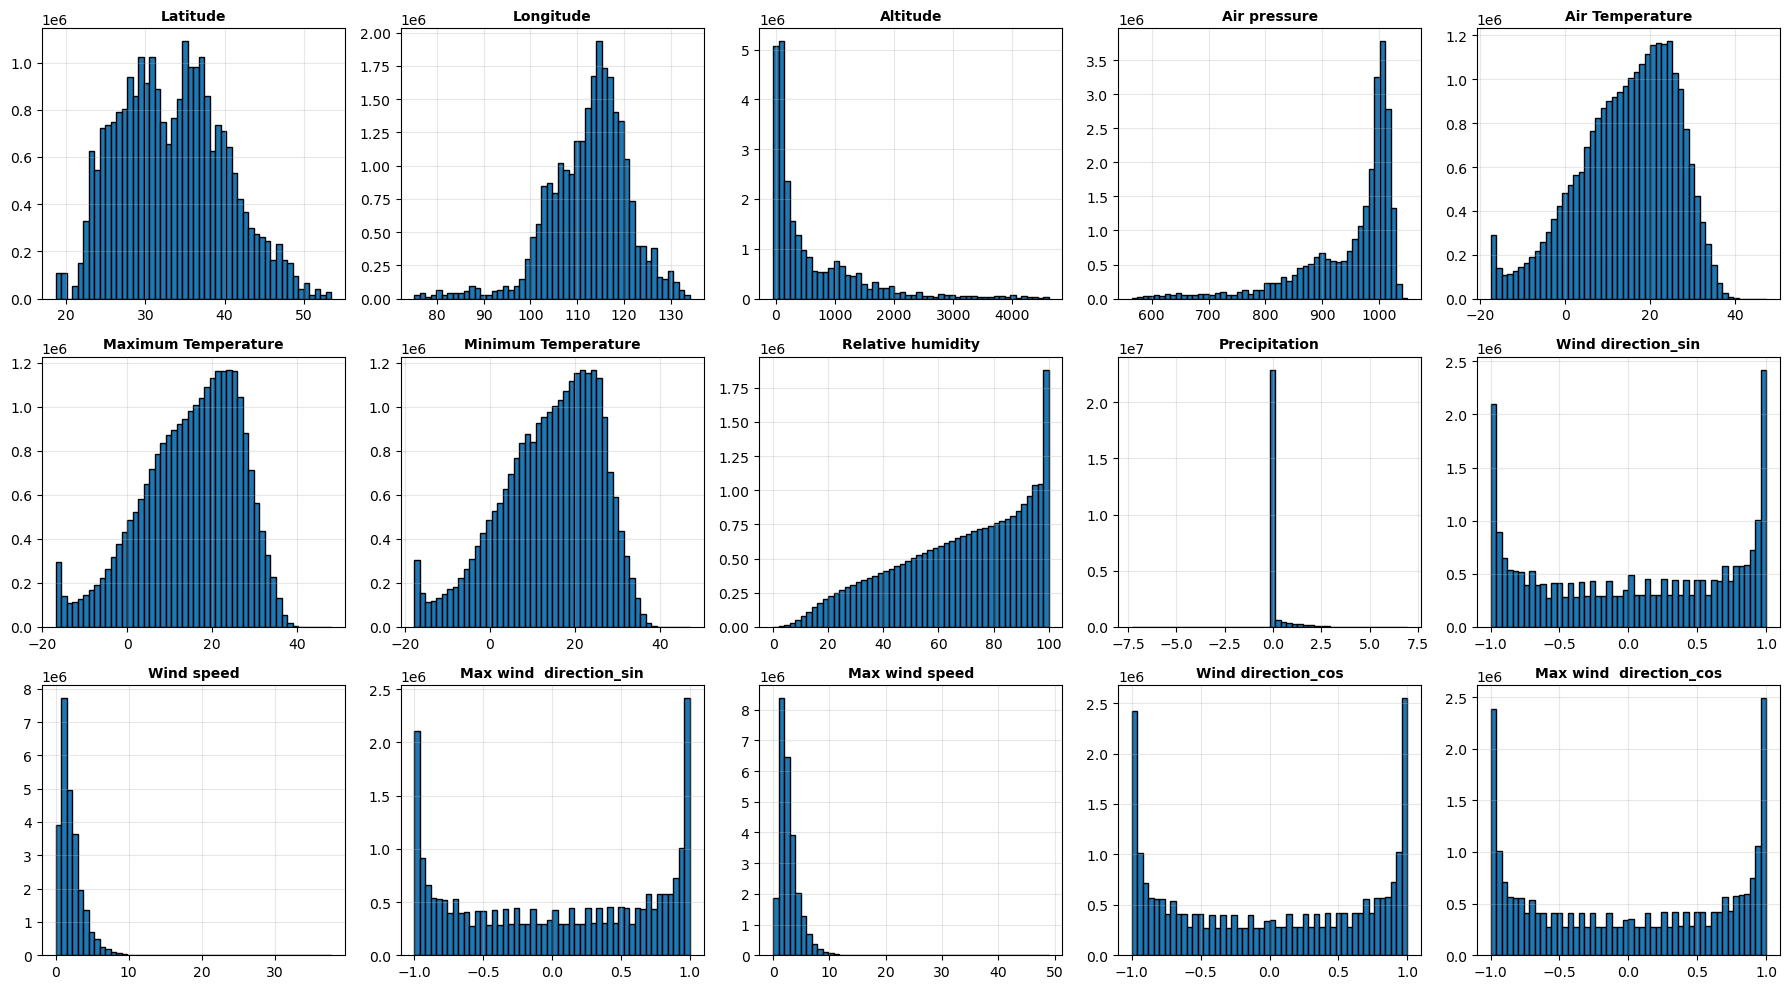

In [7]:
# Feature names
features = ['Latitude', 'Longitude', 'Altitude', 'Air pressure', 'Air Temperature', 
            'Maximum Temperature', 'Minimum Temperature', 'Relative humidity', 
            'Precipitation', 'Wind direction_sin', 'Wind speed', 
            'Max wind  direction_sin', 'Max wind speed', 'Wind direction_cos', 
            'Max wind  direction_cos']

# Visualize feature distributions
fig, axes = plt.subplots(3, 5, figsize=(18, 10))
axes = axes.flatten()

for i in range(data.shape[1]):  # All 15 features
    feature_data = data[:, i, :].flatten()
    axes[i].hist(feature_data[~np.isnan(feature_data)], bins=50, edgecolor='black')
    axes[i].set_title(f"{features[i]}", fontsize=10, fontweight='bold')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('weather_features_distribution_after_preprocessing.png', dpi=100)
plt.show()

In [9]:
# Temporal split
n_timesteps = data.shape[2]  # 13632
n_train = int(0.7 * n_timesteps)
n_val = int(0.15 * n_timesteps)

train_data = data[:, :, :n_train]
val_data = data[:, :, n_train:n_train+n_val]
test_data = data[:, :, n_train+n_val:]

print(f"Train timesteps: {train_data.shape[2]}")
print(f"Val timesteps: {val_data.shape[2]}")
print(f"Test timesteps: {test_data.shape[2]}")

# Fit scaler on train data: (stations*timesteps, features)
train_flat = train_data.reshape(-1, train_data.shape[1])  # Flatten stations and timesteps
scaler = StandardScaler()
scaler.fit(train_flat)

def normalize_data(data, scaler):
    """Normalize data using fitted scaler"""
    n_stations, n_features, n_timesteps = data.shape
    data_flat = data.reshape(-1, n_features)  # (stations*timesteps, features)
    data_normalized = scaler.transform(data_flat)
    return data_normalized.reshape(n_stations, n_features, n_timesteps)

train_norm = normalize_data(train_data, scaler)
val_norm = normalize_data(val_data, scaler)
test_norm = normalize_data(test_data, scaler)

Train timesteps: 9542
Val timesteps: 2044
Test timesteps: 2046


In [10]:
class WeatherDataset(Dataset):
    def __init__(self, data, seq_len, pred_horizon, slide_step, target_idxs):
        """
        Args:
            data: (n_stations, n_features, n_timesteps)
            seq_len: input sequence length
            pred_horizon: number of future timesteps to predict
            slide_step: sliding window step size
            target_idxs: index of target feature (mxt/mnt)
        """
        self.data = data
        self.seq_len = seq_len
        self.pred_horizon = pred_horizon
        self.slide_step = slide_step
        self.target_idxs = target_idxs
        
        # Generate all valid window indices
        self.samples = []
        n_stations, n_features, n_timesteps = data.shape
        
        for station_idx in range(n_stations):
            for start_idx in range(0, n_timesteps - seq_len - pred_horizon + 1, slide_step):
                end_idx = start_idx + seq_len
                self.samples.append((station_idx, start_idx, end_idx))
        
        print(f"Created {len(self.samples)} windows")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        station_idx, start_idx, end_idx = self.samples[idx]
        
        # Input: all features for seq_len timesteps
        X = self.data[station_idx, :, start_idx:end_idx]  # (n_features, seq_len)
        
        # Target: only mxt/mnt for next pred_horizon timesteps
        y = self.data[station_idx, self.target_idxs, end_idx:end_idx + self.pred_horizon]
        
        return torch.FloatTensor(X), torch.FloatTensor(y)

In [11]:
SEQ_LEN = 168      # 3 weeks
PRED_HORIZON = 8   # Predict next 8 timesteps (24 hours)
SLIDE_STEP = 8    # Slide by 56 steps (168 hours / 1 week)
TARGET_IDXS = [4, 5, 6, 8]

In [ ]:
train_dataset = WeatherDataset(train_norm, SEQ_LEN, PRED_HORIZON, SLIDE_STEP, TARGET_IDXS)
val_dataset = WeatherDataset(val_norm, SEQ_LEN, PRED_HORIZON, SLIDE_STEP, TARGET_IDXS)
test_dataset = WeatherDataset(test_norm, SEQ_LEN, PRED_HORIZON, SLIDE_STEP, TARGET_IDXS)

Created 2185086 windows
Created 436644 windows
Created 436644 windows


In [13]:
BATCH_SIZE = 256

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"\nDataLoader Info:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


DataLoader Info:
Train batches: 8536
Val batches: 1706
Test batches: 1706


In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model) # positional encoding matrix, each row corresponds to a position, each column to a dimension of the embedding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # (max_len, 1)

        # computing the caling factors for each embedding dimension
        # torch.arange(0, d_model, 2), selects every even dimension.
        # (-np.log(10000.0) / d_model), controls the frequency range of sine/cosine.
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        # Fill positional encoding matrix multiplying with sine for the even indices and cosine for odd ones
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        return x + self.pe[:, :x.size(1), :]

In [ ]:
class WeatherTransformer(nn.Module):
    def __init__(self, n_features, d_model, nhead, num_layers, dim_feedforward, 
                 pred_horizon, n_targets, dropout=0.1):
        
        # d_model: the hidden size of the transformer (width of each layer)
        # nhead is the number of attention layers in the multi-head attention layer
        # num_layers is the number of stacked Transformer encoder layers (depth of the model)
        super().__init__()
        
        self.n_features = n_features
        self.d_model = d_model
        self.pred_horizon = pred_horizon
        self.n_targets = n_targets
        
        # Input projection: (batch, seq_len, n_features) -> (batch, seq_len, d_model)
        self.input_projection = nn.Linear(n_features, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection: predict n_targets for pred_horizon timesteps
        self.output_projection = nn.Linear(d_model, pred_horizon * n_targets)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # x: (batch, n_features, seq_len)
        x = x.transpose(1, 2)  # -> (batch, seq_len, n_features)
        
        # Project to d_model
        x = self.input_projection(x)  # (batch, seq_len, d_model)
        x = self.pos_encoder(x)
        x = self.dropout(x)
        
        # Transformer encoding
        x = self.transformer_encoder(x)  # (batch, seq_len, d_model)
        
        # Use last timestep representation
        x = x[:, -1, :]  # (batch, d_model)
        
        # Project to output
        out = self.output_projection(x)  # (batch, pred_horizon * n_targets)
        out = out.view(-1, self.n_targets, self.pred_horizon)  # (batch, n_targets, pred_horizon)
        
        return out